# Audio Deep Learning Made Simple: Sound Classification, Step-by-Step
## Dataset Usage Testing

In [1]:
import pandas as pd
from pathlib import Path 

datasource_path = Path.home()/'dataset'/'UrbanSound8K'

# read the metadata file
metadata_file_path = datasource_path/'metadata'/'UrbanSound8K.csv'
df = pd.read_csv(metadata_file_path)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [2]:
df['path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)
df = df[['path', 'classID']]
df.head()

,path,classID
0,/fold5/100032-3-0-0.wav,3
1,/fold5/100263-2-0-117.wav,2
2,/fold5/100263-2-0-121.wav,2
3,/fold5/100263-2-0-126.wav,2
4,/fold5/100263-2-0-137.wav,2


## Audio File Reading
```python
pip install playsound
```

In [3]:
from playsound import playsound
audio_path = datasource_path/'audio'
audio_sample_path = audio_path/'fold5'/'100263-2-0-126.wav'
print(audio_sample_path)
playsound(str(audio_sample_path))

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


/root/dataset/UrbanSound8K/audio/fold5/100263-2-0-126.wav


In [4]:
from lib.wavUtil import WavOps
(sig, sr) = WavOps.open(audio_sample_path)
sig.shape, sr

(torch.Size([2, 176400]), 44100)

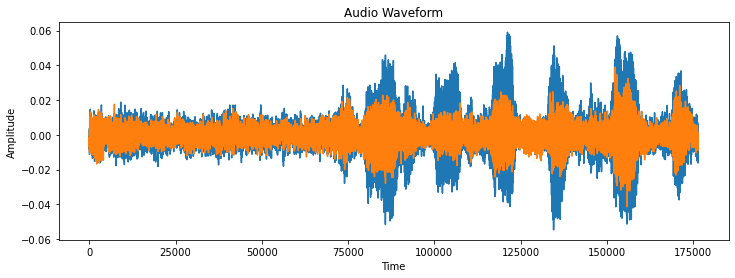

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(sig.numpy().T)
plt.title('Audio Waveform')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()

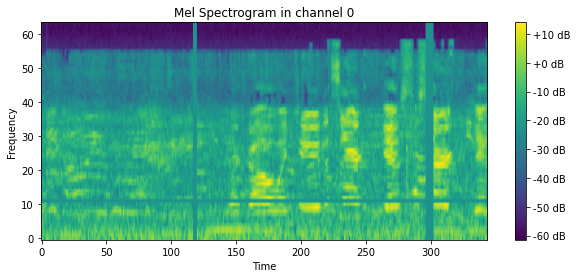

In [6]:
audio = WavOps.resampleRate(audio=(sig, sr), new_sample_rate=44100)
audio = WavOps.rechannel(audio=audio, channel_num=2)
audio = WavOps.pad_trunc(audio=audio, max_ms=4000)
audio = WavOps.time_shift(audio=audio, shift_limit=.4)
audio = WavOps.spectro_gram(audio=audio, n_mels=64, n_fft=1024, hop_len=None)
audio = WavOps.spectro_augment(spec=audio, max_mask_perctage=.03, freq_mask_num=2, time_mask_num=2)

plt.figure(figsize=(10,4))
plt.imshow(audio[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title('Mel Spectrogram in channel 0')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

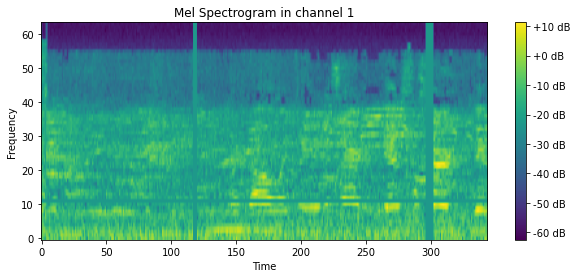

In [7]:
plt.figure(figsize=(10,4))
plt.imshow(audio[1].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title('Mel Spectrogram in channel 1')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Prepare the DataLoader

In [8]:
from torch.utils.data import DataLoader, random_split
from lib.wavDataUtil import WavDataset

audioDS = WavDataset(df, audio_path)

audio, class_id = audioDS[0]
audio.shape, class_id

(torch.Size([2, 64, 344]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]))

In [9]:
sample_num = len(audioDS)
train_num = round(sample_num * .8)
val_num = sample_num - train_num

train_ds, val_ds = random_split(audioDS, [train_num, val_num])
train_dl = DataLoader(dataset=train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(dataset=val_ds, batch_size=16, shuffle=False)

feature, label = next(iter(train_dl))
feature.shape, label

(torch.Size([16, 2, 64, 344]),
 tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]))

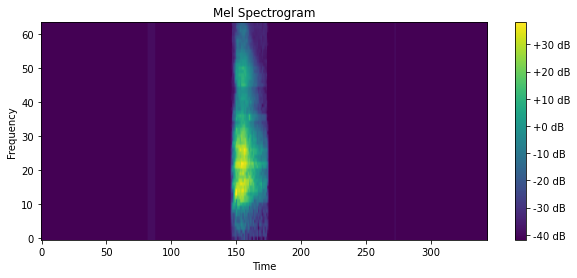

In [10]:
plt.figure(figsize=(10,4))
plt.imshow(audio[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Training

In [11]:
import torch 
from lib.acModel import AudioClassifier

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AudioClassifier().to(device=device)
model

AudioClassifier(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv): Sequential(
    (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): ReLU()
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(32, 64, kernel_

In [12]:
from lib.acModel import Processor

Processor.training(model=model, train_dl=train_dl, device=device, num_epochs=50)

Epoch: 0, Loss:2.19, accuracy:29.12%
Epoch: 1, Loss:2.04, accuracy:44.15%
Epoch: 2, Loss:1.96, accuracy:51.53%
Epoch: 3, Loss:1.91, accuracy:56.68%
Epoch: 4, Loss:1.86, accuracy:61.49%
Epoch: 5, Loss:1.82, accuracy:65.52%
Epoch: 6, Loss:1.80, accuracy:67.48%
Epoch: 7, Loss:1.76, accuracy:70.90%
Epoch: 8, Loss:1.74, accuracy:72.87%
Epoch: 9, Loss:1.73, accuracy:73.96%
Epoch: 10, Loss:1.72, accuracy:74.43%
Epoch: 11, Loss:1.71, accuracy:76.12%
Epoch: 12, Loss:1.70, accuracy:76.78%
Epoch: 13, Loss:1.68, accuracy:78.63%
Epoch: 14, Loss:1.68, accuracy:78.81%
Epoch: 15, Loss:1.68, accuracy:78.80%
Epoch: 16, Loss:1.67, accuracy:79.09%
Epoch: 17, Loss:1.66, accuracy:80.32%
Epoch: 18, Loss:1.65, accuracy:81.71%
Epoch: 19, Loss:1.65, accuracy:81.52%
Epoch: 20, Loss:1.64, accuracy:82.29%
Epoch: 21, Loss:1.65, accuracy:81.62%
Epoch: 22, Loss:1.63, accuracy:83.19%
Epoch: 23, Loss:1.63, accuracy:83.94%
Epoch: 24, Loss:1.63, accuracy:83.81%
Epoch: 25, Loss:1.62, accuracy:84.67%
Epoch: 26, Loss:1.61, 

## Validation

In [13]:
Processor.inference(model=model, val_dl=val_dl, device=device)

Validation accuracy: 91.408935%, Validation sample size is: 1746.0
